## Modelagem IMDB

Explique como você faria a previsão da nota do imdb a partir dos dados. Quais variáveis e/ou suas transformações você utilizou e por quê? Qual tipo de problema estamos resolvendo (regressão, classificação)? Qual modelo melhor se aproxima dos dados e quais seus prós e contras? Qual medida de performance do modelo foi escolhida e por quê?


### Importando as bibliotecas

In [14]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings("ignore")
import joblib

### Carregando o dataset

In [72]:
# Carregar o dataset
df = pd.read_csv('desafio_indicium_imdb.csv', index_col=0)

# Mostrar as primeiras linhas do dataset
df.head()

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
1,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
2,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
3,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
4,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"
5,The Lord of the Rings: The Return of the King,2003,U,201 min,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,"377,845,905"


In [74]:
# Separar as features e o target
X = df.drop('IMDB_Rating', axis=1)
y = df['IMDB_Rating']

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Com todo o conhecimento que já possuo dos dados após ter feito toda a análise exploratória, faço os passos de pré-processamento e tratamento dos dados abaixo, com o obejtivo de possibilitar uma predição mais robusta dos dados...

In [77]:
# Identificar características numéricas e categóricas no conjunto de dados X
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Definir transformadores para características numéricas e categóricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Preencher valores ausentes com a média
    ('normalização', StandardScaler())])          # Normalizar os valores numéricos (padronização)

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Preencher valores ausentes com o valor mais frequente
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])   # Codificar variáveis categóricas usando one-hot encoding

# Combinar transformadores em um pré-processador de colunas
preprocessor = ColumnTransformer(
    transformers=[
        ('numérica', numeric_transformer, numeric_features),     # Aplicar transformação numérica às características numéricas
        ('categórica', categorical_transformer, categorical_features)])  # Aplicar transformação categórica às características categóricas

In [30]:
# Definição dos modelos base de regressão
models = {
    'LR': LinearRegression(),
    'DT': DecisionTreeRegressor(),
    'RF': RandomForestRegressor(),
    'GB': GradientBoostingRegressor(),
    'MLP': MLPRegressor(),
    'SVR': SVR()
}

In [78]:
# Definição das distribuições de parâmetros para otimização de hiperparâmetros
param_distributions = {
    'LR': {},  
    'DT': {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 10, 20]},  
    'RF': {'n_estimators': [50, 100, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, None], 'min_samples_split': [2, 5, 10]},  
    'GB': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 4, 5]},  
    'MLP': {'hidden_layer_sizes': [(50,50), (100,)], 'activation': ['relu', 'tanh'], 'solver': ['adam', 'sgd']},  
    'SVR': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}  
}

# Otimização de hiperparâmetros e treinamento dos melhores estimadores
best_estimators = {}
for name, model in models.items():
    # Configuração do RandomizedSearchCV para o modelo atual
    search = RandomizedSearchCV(model, param_distributions[name], n_iter=10, scoring='neg_mean_squared_error', cv=5, random_state=42)
    
    # Construção do pipeline com pré-processamento e modelo
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), (name, search)])
    
    # Treinamento do pipeline
    pipeline.fit(X_train, y_train)
    
    # Armazenamento do melhor estimador encontrado pelo RandomizedSearchCV
    best_estimators[name] = pipeline.named_steps[name].best_estimator_

In [79]:
# Criar o Voting Regressor com os melhores estimadores
voting_regressor = VotingRegressor(estimators=[
    ('LR', best_estimators['LR']),
    ('DT', best_estimators['DT']),
    ('RF', best_estimators['RF']),
    ('GB', best_estimators['GB']),
    ('MLP', best_estimators['MLP']),
    ('SVR', best_estimators['SVR'])
])

# Pipeline final
final_pipeline = Pipeline(steps=[('Pré-Processamento', preprocessor), ('Ensemble Voting', voting_regressor)])
# Fazendo o treinamento do modelo desenvolvido
final_pipeline.fit(X_train, y_train)

Pipeline(steps=[('Pré-Processamento',
                 ColumnTransformer(transformers=[('numérica',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('normalização',
                                                                   StandardScaler())]),
                                                  Index(['Meta_score', 'No_of_Votes'], dtype='object')),
                                                 ('categórica',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Ind...
                 VotingRegressor(estimators=[('LR', LinearRegression()),
                                             ('DT',
                                              DecisionTreeRegressor(max_depth=10,
                                                                    min_samples_split=20)),
                                             ('RF',
                                              RandomForestRegressor(max_depth=30,
                                                                    max_features='sqrt',
                                                                    min_samples_split=5,
                                                                    n_estimators=200)),
                                             ('GB',
                                              GradientBoostingRegressor(max_depth=5)),
                                             ('MLP',
                                              MLPRegressor(hidden_layer_sizes=(50,
                                                                               50),
                                                           solver='sgd')),
                                             ('SVR',
                                              SVR(C=0.1, kernel='linear'))]))])

In [80]:
# Realização da previsão com o modelo final e avaliação dos resultados

y_pred = final_pipeline.predict(X_test)  # Realiza previsões usando o modelo finalizado no conjunto de teste que foi separado e que não sofreu interferências

# Cálculo das métricas de avaliação
mae = mean_absolute_error(y_test, y_pred)  # Calcula o erro médio absoluto
mse = mean_squared_error(y_test, y_pred)   # Calcula o erro quadrático médio
rmse = np.sqrt(mse)                        # Calcula a raiz do erro quadrático médio (RMSE)
r2 = r2_score(y_test, y_pred)              # Calcula o coeficiente de determinação R^2

# Apresentado os resultados
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R^2: {r2}')

MAE: 0.17357179596807512
MSE: 0.04593550608013049
RMSE: 0.2143257009323205
R^2: 0.3002329827534813


### Salvando o modelo desenvolvido em formato .pkl 

In [81]:
# Salvando o modelo
joblib.dump(final_pipeline, 'avaliacao_imdb_model.pkl')

['avaliacao_imdb_model.pkl']

### Predição da avaliação IMDb do filme 'The Shawshank Redemption'

In [82]:
# Carregando o modelo salvo para fazer a predição de avaliação do filme
modelo_predicao = joblib.load('avaliacao_imdb_model.pkl')

In [87]:
# Características do novo filme
novo_filme = {
    'Series_Title': 'The Shawshank Redemption',
    'Released_Year': '1994',
    'Certificate': 'A',
    'Runtime': '142 min',
    'Genre': 'Drama',
    'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
    'Meta_score': 80.0,
    'Director': 'Frank Darabont',
    'Star1': 'Tim Robbins',
    'Star2': 'Morgan Freeman',
    'Star3': 'Bob Gunton',
    'Star4': 'William Sadler',
    'No_of_Votes': 2343110,
    'Gross': '28,341,469'
}

# Criar um DataFrame com as características do novo filme
novo_filme_df = pd.DataFrame([novo_filme])

# Fazer a previsão
predicted_imdb_score = modelo_predicao.predict(novo_filme_df)

print(f'A nota de avaliação IMDb do filme The Shawshank Redemption, foi: {round(predicted_imdb_score[0],2)}')

A nota de avaliação IMDb do filme The Shawshank Redemption, foi: 8.79


## Apêndice de trabalho

### Conversão de variáveis e tratamento da base de dados
Abaixo são feitos alguns tratamentos, como a remoção de linhas duplicadas e a conversão de colunas com valores numéricos importantes que inicialmente na base de dados estavam classificadas como categóricas. 

In [ ]:
# Remover linhas duplicadas
df = df.drop_duplicates()

In [ ]:
# Converter colunas para o tipo numérico quando apropriado
df['Released_Year'] = pd.to_numeric(df['Released_Year'], errors='coerce')
df['Meta_score'] = pd.to_numeric(df['Meta_score'], errors='coerce')
df['IMDB_Rating'] = pd.to_numeric(df['IMDB_Rating'], errors='coerce')
df['No_of_Votes'] = pd.to_numeric(df['No_of_Votes'], errors='coerce')

# Função para converter Runtime apenas em minutos
def convert_runtime(runtime_str):
    # Remove ' min' e converte para int
    minutes = int(runtime_str.replace(' min', ''))
    return minutes  # Retorna apenas o número de minutos como inteiro

# Aplica a função de conversão à coluna Runtime
df['Runtime'] = df['Runtime'].apply(convert_runtime)

# Remover caracteres não numéricos da coluna 'Gross' e converter para float essa coluna de faturamento
df['Gross'] = df['Gross'].replace('[\$,]', '', regex=True).astype(float)


**Após isso, é iniciado o tratamento dos valores nulos da base de dados.**

Inicialmente é feito a proporção de valores nulos em cada coluna.

In [ ]:
# Calcular a proporção de valores nulos em cada coluna
null_proportion = df.isnull().mean() * 100

# Exibir a proporção de valores nulos
print(null_proportion)

Series_Title      0.000000
Released_Year     0.100100
Certificate      10.110110
Runtime           0.000000
Genre             0.000000
IMDB_Rating       0.000000
Overview          0.000000
Meta_score       15.715716
Director          0.000000
Star1             0.000000
Star2             0.000000
Star3             0.000000
Star4             0.000000
No_of_Votes       0.000000
Gross            16.916917
dtype: float64


Inicialmente é feito a exclusão da única linha nula da coluna 'Released_Year', como podemos ver na proporção de valores nulos acima, a exclusão dessa única linha não trará perca de informação da base de dados em todo o processo exploratório e preditivo que farei.

In [ ]:
# Excluir linhas nulas na coluna Released Year, que no caso só possui uma linha nula
df = df.dropna(subset=['Released_Year'])

Logo, para colunas, como a de faturamento 'Gross' e a de 'Meta_score', a decisão sobre excluir valores nulos de um DataFrame depende de vários fatores, incluindo a proporção de valores ausentes, o impacto potencial dessa exclusão na análise e a natureza dos dados.

Mas tem umas orientações mais gerais que a comunidade no geral segue, sendo elas:

Baixa Proporção de Valores Nulos: Se menos de 5% dos dados estão ausentes, geralmente é seguro excluir esses valores sem afetar significativamente a análise.

Proporção Moderada de Valores Nulos (5-20%): Nessa faixa, a decisão depende do contexto e da importância das variáveis com valores ausentes. Substituir valores nulos por uma estatística (média, mediana, moda) ou usando técnicas de imputação pode ser mais adequado.

Alta Proporção de Valores Nulos (>20%): Se mais de 20% dos dados estão ausentes, excluir esses valores pode resultar na perda de informações importantes. Nesse caso, técnicas de imputação ou modelagem para lidar com valores ausentes são recomendadas.

A coluna **'Meta_score'** por exemplo, possui uma proporção de mais de 15% de valores nulos. Logo, excluir todas as linhas nulas dessa coluna pode causar uma grande perca de informação dos dados. Então, nesse caso, substituir valores nulos por uma estatística (média, mediana, moda) pode ser mais adequado.

Então, para tentar compreender qual substituição é mais devida para essa coluna, utilizaremos visualizações analíticas para auxiliar nessa escolha.

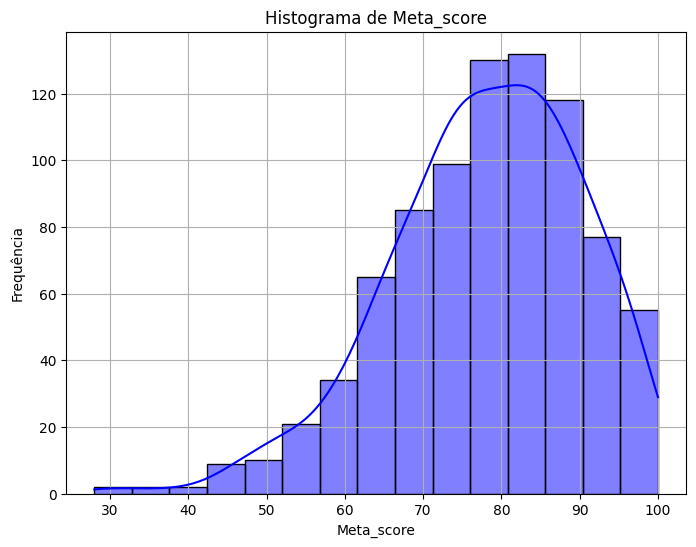

In [ ]:
# Plotar o histograma de Meta_score
plt.figure(figsize=(8, 6))
sns.histplot(df['Meta_score'].dropna(), bins=15, kde=True, color='blue', edgecolor='black')
plt.title('Histograma de Meta_score')
plt.xlabel('Meta_score')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()

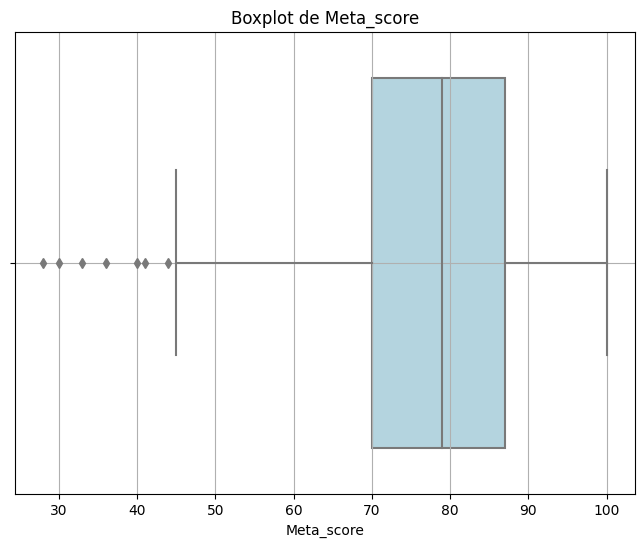

In [ ]:
# Plotar o boxplot de Meta_score
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['Meta_score'], color='lightblue')
plt.title('Boxplot de Meta_score')
plt.xlabel('Meta_score')
plt.grid(True)
plt.show()

A análise do histograma revela que a coluna **'Meta_score'** exibe uma distribuição normalizada de seus valores. Portanto, optaremos por utilizar a **média** para substituição de dados faltantes, como observado. Além disso, conforme indicado pelo boxplot, a média e a mediana são aproximadamente iguais, reforçando que a média é uma estimativa confiável para valores ausentes.


In [ ]:
# Calcular a média da coluna Meta_score
mean_meta = df['Meta_score'].mean()

# Imputar valores nulos com a média
df['Meta_score'].fillna(mean_meta, inplace=True)

# Verificar se os valores nulos foram preenchidos
print(df['Meta_score'].isnull().sum())

0


Já a coluna **'Gross'**, possui uma proporção de mais de 16% de valores nulos. Como falado anteriormente, excluir todas as linhas nulas pode causar uma grande perca de informação dos dados, podendo impossibilitar no processo exploratório e preditivo, entendimentos importantes sobre os dados.

Sendo assim, para dá continuidade à análise exploratória, os valores nulos da coluna **Gross** que representa valores financeiros e pode ter uma distribuição assimétrica com muitos outliers (alguns filmes têm faturamentos extremamente altos em comparação com a maioria), serão substituídos pela **mediana**, que é normalmente a **melhor** escolha para esses valores financeiros.

In [ ]:
# Calcular a mediana da coluna 'Gross'
median_gross = df['Gross'].median()

# Imputar valores nulos com a mediana
df['Gross'].fillna(median_gross, inplace=True)

# Verificar se os valores nulos foram preenchidos
print(df['Gross'].isnull().sum())

0


In [4]:
'''# Seleção de variáveis
X = df[['Released_Year', 'Runtime', 'Meta_score', 'No_of_Votes', 'Gross']]
y = df['IMDB_Rating']

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinar o modelo
model = LinearRegression()
model.fit(X_train, y_train)

# Fazer previsões
y_pred = model.predict(X_test)

# Avaliar o modelo
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')'''

Root Mean Squared Error: 0.21075340555277375
